# VAE를 이용한 생성 모델
- Variational Autoencoder은 오코인코더를 개선하여 평균과 표준편차 두개의 성분을 나타내는 두개의 임베딩 벡터를 생성하게 한다
- 이를 이용하면 생성 모델을 확률적으로 조절하기가 수월해진다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-23%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.06.41.png?raw=1" width =600>

- 새로운 분자의 구조를 생성하는 모델에 적용할 수 있다
- 분자 표현으로 SMILES를 사용하며 새로운 SMILES를 얻는다
 - MolrculeNet이 제공하는 SMILES 데이터셋 MUV 사용 (약 90000개 제공)
 - Maximum Unbiased Validation(MUV) - 17개의 태스크 포함
- [VAE 소개](https://towardsdatascience.com/an-introduction-to-variational-auto-encoders-vaes-803ddfb623df)

# import

In [2]:
!pip install DeepChem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [3]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers

import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina'

# 학습 데이터

In [4]:
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

# SMILES 문자열의 규칙을 파악: 문자(토큰)의 목록, 문자열의 최대길이 등

tokens = set()
for s in train_smiles:
  tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

# VAE 모델

- AspuruGuzikAutoEncoder 사용: 인코더는 합성곱신경망을, 디코더는 순환신경망을 사용
- 학습속도를 조절하기 위해서 ExponentialDecay를 사용한다
 - 0.001에서 시작하고 이포크마다 0.95배씩 감소시킨다
- 학습된 모델을 vae 폴더에 저장한다
 - 나중에 모델을 이용하려면 vae 폴더를 구글 드라이브 등에 저장했다가 restore하여 사용한다

In [5]:
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder
from deepchem.models.optimizers import ExponentialDecay
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size
learning_rate = ExponentialDecay(0.001, 0.95, batches_per_epoch)
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='vae',
                batch_size=batch_size, learning_rate=learning_rate)

# 시퀀스 생성 함수 정의

def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

## 모델 학습

In [6]:
# AspuruGuzikAutoEncoder이 제공하는 자체 학습 함수 (이포크수 지정)
model.fit_sequences(generate_sequences(50)) # 50 이포크 수

## 모델 restore()
- 이미 학습된 모델을 불러오는 방법
- 학습된 모델이 구글 드라이브에 저장되어 있는 경우

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='/content/drive/MyDrive/vae',
                batch_size=batch_size, learning_rate=learning_rate)
model.restore()

# 분자 생성

- 학습된 모델을 이용하여 새로운 분자를 만든다
- 모델에 들어가는 벡터의 크기를 지정한다 (예: 196)
- 벡터를 2000개 생성하겠다
- 생성된 분자들중 유효한 SMILES를 걸러내기 위해서 RDKit의 MolFromSmiles를 사용한다

In [8]:
from rdkit import Chem
predictions = model.predict_from_embeddings(np.random.normal(size=(2000,196)))
molecules = []
for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)
print()
print('Generated molecules:')
for m in molecules:
  print(m)

[07:43:17] SMILES Parse Error: duplicated ring closure 2 bonds atom 23 to itself for input: 'CCC1CCCC1cc(Nc2nnnnn(C)nn2C)n1nnn221'
[07:43:17] SMILES Parse Error: extra close parentheses while parsing: CCCC)Cn1cnc((F))n)ccnc2cn(N))n3)n(N)cnc1
[07:43:17] SMILES Parse Error: Failed parsing SMILES 'CCCC)Cn1cnc((F))n)ccnc2cn(N))n3)n(N)cnc1' for input: 'CCCC)Cn1cnc((F))n)ccnc2cn(N))n3)n(N)cnc1'
[07:43:17] SMILES Parse Error: extra close parentheses while parsing: c1ccc(C)cnnnc(CCCCF)F)n)(())))n))nn2
[07:43:17] SMILES Parse Error: Failed parsing SMILES 'c1ccc(C)cnnnc(CCCCF)F)n)(())))n))nn2' for input: 'c1ccc(C)cnnnc(CCCCF)F)n)(())))n))nn2'
[07:43:17] SMILES Parse Error: extra close parentheses while parsing: Cc1ccccccc1)CCCCCCCCCCCCC)nn2))c2ccc22
[07:43:17] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccccc1)CCCCCCCCCCCCC)nn2))c2ccc22' for input: 'Cc1ccccccc1)CCCCCCCCCCCCC)nn2))c2ccc22'
[07:43:17] SMILES Parse Error: syntax error while parsing: CCN(C)Cn1c(N)C()c2c(c3c2C)n(C)cnnn(C)n3n2cc1C


Generated molecules:
CCCCCCCCCCCC
COCCCCCCCCC
NCCCCCCC
N
N
N1ccCCCCCCCCCC1CCCCCC
C=CCCC1cnccCCCCCC2CC2CCCCCC1CC
OCNCCCCNCCCCC1CCCCCNNNCCCCCCCCC1C
NNCCCCCCCNCCCCCCCCCCCNCCCCCCCCCCCC


[07:43:18] SMILES Parse Error: extra close parentheses while parsing: CC1C1CC1CCC2)cccccc22NN1CCC())n(FF))
[07:43:18] SMILES Parse Error: Failed parsing SMILES 'CC1C1CC1CCC2)cccccc22NN1CCC())n(FF))' for input: 'CC1C1CC1CCC2)cccccc22NN1CCC())n(FF))'
[07:43:18] SMILES Parse Error: extra close parentheses while parsing: C11ccc2cCCN2cCC2CCCCF)cn1c1C)11CCCC
[07:43:18] SMILES Parse Error: Failed parsing SMILES 'C11ccc2cCCN2cCC2CCCCF)cn1c1C)11CCCC' for input: 'C11ccc2cCCN2cCC2CCCCF)cn1c1C)11CCCC'
[07:43:18] SMILES Parse Error: syntax error while parsing: CcCc1nnc(N)c(CN3)(n1c(N1c(()())nnnccc2ccc
[07:43:18] SMILES Parse Error: Failed parsing SMILES 'CcCc1nnc(N)c(CN3)(n1c(N1c(()())nnnccc2ccc' for input: 'CcCc1nnc(N)c(CN3)(n1c(N1c(()())nnnccc2ccc'
[07:43:18] SMILES Parse Error: extra close parentheses while parsing: Cc1c1cc11C1c(ccccc2nn11CCCCCCCCCF)FFF)FF)))
[07:43:18] SMILES Parse Error: Failed parsing SMILES 'Cc1c1cc11C1c(ccccc2nn11CCCCCCCCCF)FFF)FF)))' for input: 'Cc1c1cc11C1c(ccccc2nn11CCCC

In [9]:
molecules

['CCCCCCCCCCCC',
 'COCCCCCCCCC',
 'NCCCCCCC',
 'N',
 'N',
 'N1ccCCCCCCCCCC1CCCCCC',
 'C=CCCC1cnccCCCCCC2CC2CCCCCC1CC',
 'OCNCCCCNCCCCC1CCCCCNNNCCCCCCCCC1C',
 'NNCCCCCCCNCCCCCCCCCCCNCCCCCCCCCCCC']

# 유효한 분자 필터링

- 생성된 SMILES 들에 대해서 유효하지 않거나 약물로서 가치가 없는 분자를 걸러내야 한다
- 제거하고 싶은 분자가 있는지 찾는다
- MolFromSmiles()을 사용해 SMILES 문자열들을 분자 객체로 변환한다
- 분자의 크기를 확인한다 (10보다 작으면 상호작용에 필요한 에너지가 불충분하고, 50 이상이면 분자의 용해도가 너무 낮아 문제가 된다)
- 수소를 제외한 분자의 크기를 GetNumAtoms()로 얻는다
- 약물과 얼마나 유사한지를 판단하기 위해서 QED(Quantitave Estimate of Drugness)를 많이 사용한다
 - QED: 계산된 속성 집합과 판매된 약물의 동일한 특성 분포를 정량화 한 것 (Richard Bickerton 이 제안)
 - 1에 가까울수록 기존의 약물과 유사하다고 본다
 - QED > 0.5 인 분자만 고른 후 결과를 시각화 한다

In [10]:
from rdkit import Chem
molecules_new = [Chem.MolFromSmiles(x) for x in molecules]
print(sorted(x.GetNumAtoms() for x in molecules_new))

[1, 1, 8, 11, 12, 19, 25, 31, 34]


In [11]:
good_mol_list = [x for x in molecules_new if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

6


In [12]:
good_mol_list

In [13]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]

In [14]:
qed_list

[0.4304643040524984,
 0.49196836275044803,
 0.6052975347994594,
 0.4629767404982181,
 0.2128133438223573,
 0.04588020930255223]

In [15]:
final_mol_list = [(a,b) for a,b in zip(good_mol_list, qed_list) if b > 0.5] #
final_mol_list

[(<rdkit.Chem.rdchem.Mol at 0x79892c3e85f0>, 0.6052975347994594)]

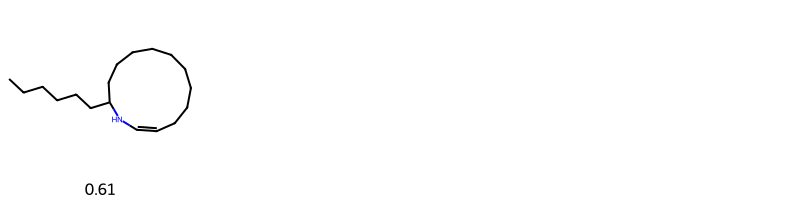

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw
img=Draw.MolsToGridImage([x[0] for x  in final_mol_list],
                         molsPerRow=4,subImgSize=(200,200),
                         legends=[f"{x[1]:.2f}" for x in final_mol_list])
img

In [19]:
predictions_2 = model.predict_from_embeddings(np.random.normal(size=(10,196)))
molecules_2 = []
for p in predictions_2:
  smiles = ''.join(p)
  # if Chem.MolFromSmiles(smiles) is not None:
  molecules_2.append(smiles)

molecules_2

['O=CC)CCCCccc())n1)1))cncnnn())n22',
 'CC1CC1cc(cc(()c(-c2cc3nncc()nnnc(C)n1C',
 'CO1ccccccc1CC1CC21CCCccCCCCCCCCCCCCCCCCCCC)))11111',
 'Cc1nn(CCF)1ccccnnn1-c1nnnn32))nn2))11',
 'CCCC)CCc1cnc(C)cc-cn--cnnn-)nccc',
 'C11c(N2c(C2FF)ccnn1-c1nnnn(C)n3nn3C)nn)',
 'CCCC)CC(c2nnc(Cc3nc(N)ncC)CCn2nnnnn2)cc',
 'CC1Cn2nnnc(()n(C)nncn2nnnnnn)C))))))',
 'Cc1ccc(C)cccc2c(C)n(C)nnnnn(C)nnn3s2)n1',
 'CC1C)c1c(NC=CCNCNNNNN2CCCCCCCCCCCCC']